In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
import util.plot as plot
import util.download

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 32 # original size = 32
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
#     T.Lambda(lambda x: x.repeat(3, 1, 1)),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

# https://www.cs.toronto.edu/~kriz/cifar.html
cf_ds = torchvision.datasets.CIFAR10(DATA_DIR.joinpath('cifar'), download=True, transform=tf)
cf_dl = torch.utils.data.DataLoader(cf_ds, batch_size=4, shuffle=False, num_workers=1)

Files already downloaded and verified


Found 50000 images in dataset folder.


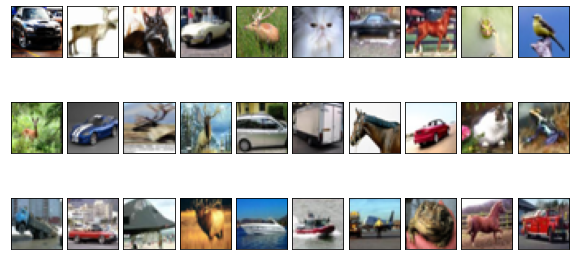

In [4]:
_ = plot.dataset_first_n(cf_ds, 30, figsize=(10,5), nrows=3)
print(f'Found {len(cf_ds)} images in dataset folder.')

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
import acgan as gan

print("### Image size")
x0, y0 = cf_ds[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

print("#### Discriminator")
dsc = gan.Discriminator(in_size=x0[0].shape, num_classes=10).to(device)
print(dsc)

print("### Discriminator output shape")
d0_y, d0_c = dsc(x0)
print(d0_y.shape, d0_c.shape)


print("### Generator")
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

print("### Generator output shape")
z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

### Image size
torch.Size([1, 3, 32, 32])
#### Discriminator
Discriminator(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReL

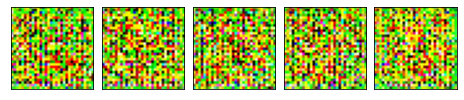

In [7]:
samples, labels = gen.sample(5, with_grad=False)
_ = plot.tensors_as_images(samples.cpu())

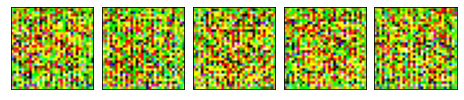

In [8]:
samples, labels = gen.sample_cats(5, [1,2,3,4,5])
_ = plot.tensors_as_images(samples.cpu())

In [9]:
import torch.optim as optim
from torch.utils.data import DataLoader

torch.manual_seed(999)

# Hyperparams
hp = dict(
        batch_size=100, z_dim=1024, data_label=1, label_noise=0.3,
        discriminator_optimizer=dict(
            type='Adam', 
            lr=0.0002,
            weight_decay=0.02,
            betas=(0.5, 0.999)
        ),
        generator_optimizer=dict(
            type='Adam',  
            lr=0.0002,
            weight_decay=0.02,
            betas=(0.5, 0.999)
        ),
    )
    

# Data
dl_train = torch.utils.data.DataLoader(cf_ds, batch_size=hp['batch_size'], shuffle=True, num_workers=1)
im_size = cf_ds[0][0].shape

# Model
dsc = gan.Discriminator(im_size, num_classes=10).to(device)
gen = gan.Generator(z_dim, featuremap_size=4, out_channels=3).to(device)

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
gen.apply(weights_init)
dsc.apply(weights_init)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)

dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_data_class_soft, real_class_labels, y_generated, y_generated_class_soft, fake_class_labels):
    return gan.discriminator_loss_fn(y_data, y_data_class_soft, real_class_labels, 
                                     y_generated, y_generated_class_soft, fake_class_labels,
                                     hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated, y_generated_class_soft, fake_class_labels):
    return gan.generator_loss_fn(y_generated, y_generated_class_soft, fake_class_labels, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/acgan-cifar10'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 100, 'z_dim': 1024, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.02, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.02, 'betas': (0.5, 0.999)}}


--- EPOCH 1/15 ---
  0%|          | 1/500 [00:00<06:55,  1.20it/s]

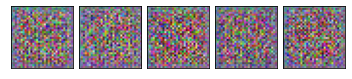

 20%|██        | 101/500 [01:07<04:27,  1.49it/s]

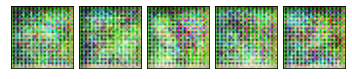

 40%|████      | 201/500 [02:14<03:21,  1.49it/s]

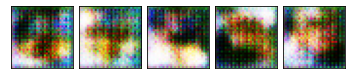

 60%|██████    | 301/500 [03:22<02:14,  1.48it/s]

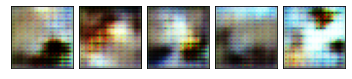

 80%|████████  | 401/500 [04:30<01:06,  1.49it/s]

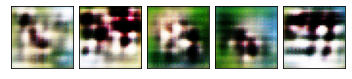

100%|██████████| 500/500 [05:37<00:00,  1.48it/s]
Discriminator loss: 1.9430334441661834
Generator loss:     1.0981812883019448


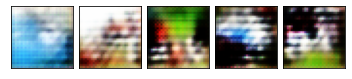

--- EPOCH 2/15 ---
  0%|          | 1/500 [00:00<06:09,  1.35it/s]

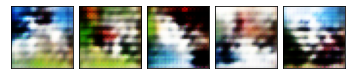

 20%|██        | 101/500 [01:08<04:29,  1.48it/s]

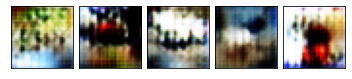

 40%|████      | 201/500 [02:16<03:21,  1.48it/s]

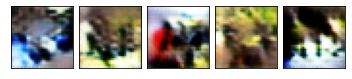

 60%|██████    | 301/500 [03:23<02:14,  1.48it/s]

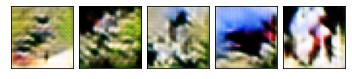

 80%|████████  | 401/500 [04:31<01:06,  1.49it/s]

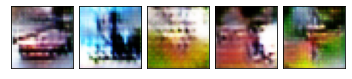

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.5684939233064652
Generator loss:     0.7862313560247421


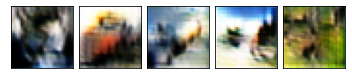

--- EPOCH 3/15 ---
  0%|          | 1/500 [00:00<06:04,  1.37it/s]

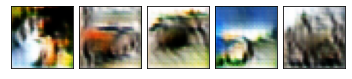

 20%|██        | 101/500 [01:08<04:29,  1.48it/s]

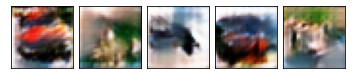

 40%|████      | 201/500 [02:16<03:22,  1.48it/s]

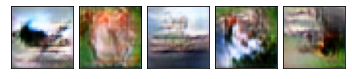

 60%|██████    | 301/500 [03:23<02:14,  1.48it/s]

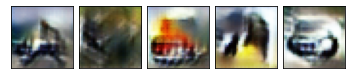

 80%|████████  | 401/500 [04:31<01:06,  1.48it/s]

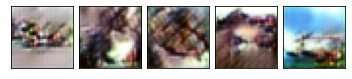

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.4794963364601135
Generator loss:     0.687304024219513


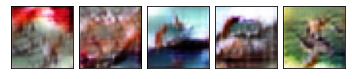

--- EPOCH 4/15 ---
  0%|          | 1/500 [00:00<06:08,  1.35it/s]

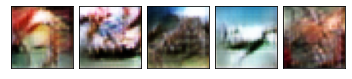

 20%|██        | 101/500 [01:08<04:29,  1.48it/s]

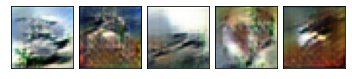

 40%|████      | 201/500 [02:16<03:21,  1.48it/s]

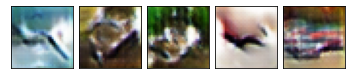

 60%|██████    | 301/500 [03:23<02:13,  1.49it/s]

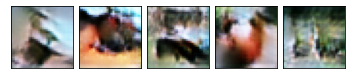

 80%|████████  | 401/500 [04:31<01:06,  1.48it/s]

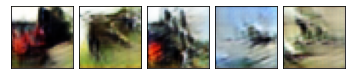

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.3780439865589142
Generator loss:     0.6654403036236763


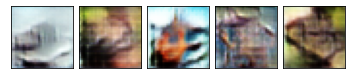

--- EPOCH 5/15 ---
  0%|          | 1/500 [00:00<06:06,  1.36it/s]

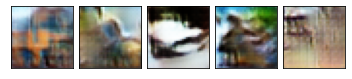

 20%|██        | 101/500 [01:08<04:28,  1.49it/s]

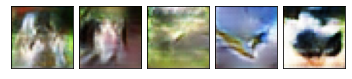

 40%|████      | 201/500 [02:16<03:21,  1.48it/s]

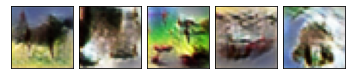

 60%|██████    | 301/500 [03:23<02:14,  1.48it/s]

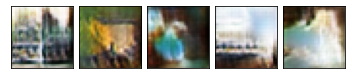

 80%|████████  | 401/500 [04:31<01:06,  1.49it/s]

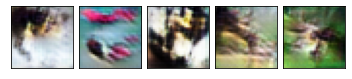

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.3196679097414017
Generator loss:     0.6639234803915024
Saved checkpoint.


/anaconda/envs/noam-ai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/noam-ai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/noam-ai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/noam-ai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvTranspose2d. It won't be checked for correctness upon loading.
  "type " + obj.__na

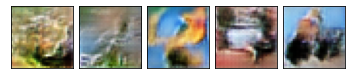

--- EPOCH 6/15 ---
  0%|          | 1/500 [00:00<06:04,  1.37it/s]

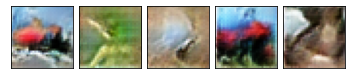

 20%|██        | 101/500 [01:08<04:29,  1.48it/s]

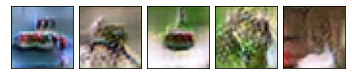

 40%|████      | 201/500 [02:16<03:21,  1.48it/s]

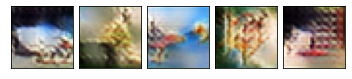

 60%|██████    | 301/500 [03:23<02:13,  1.49it/s]

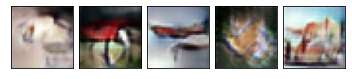

 80%|████████  | 401/500 [04:31<01:06,  1.49it/s]

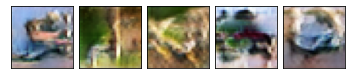

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.2778674535751342
Generator loss:     0.6564448190331459


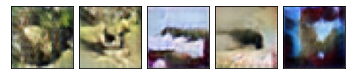

--- EPOCH 7/15 ---
  0%|          | 1/500 [00:00<06:07,  1.36it/s]

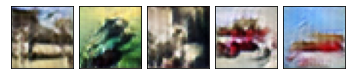

 20%|██        | 101/500 [01:08<04:28,  1.49it/s]

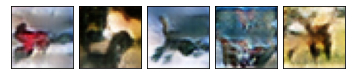

 40%|████      | 201/500 [02:16<03:21,  1.49it/s]

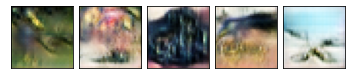

 60%|██████    | 301/500 [03:23<02:13,  1.49it/s]

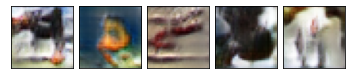

 80%|████████  | 401/500 [04:31<01:06,  1.49it/s]

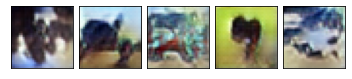

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.2451837788820266
Generator loss:     0.6541894465684891


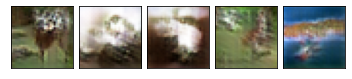

--- EPOCH 8/15 ---
  0%|          | 1/500 [00:00<06:04,  1.37it/s]

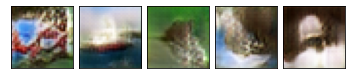

 20%|██        | 101/500 [01:08<04:28,  1.48it/s]

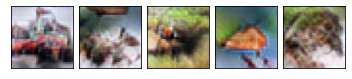

 40%|████      | 201/500 [02:16<03:22,  1.48it/s]

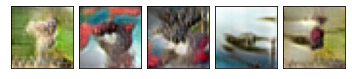

 60%|██████    | 301/500 [03:23<02:13,  1.49it/s]

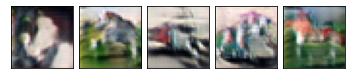

 80%|████████  | 401/500 [04:31<01:06,  1.49it/s]

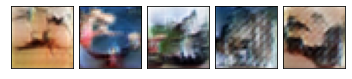

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.2175935550928116
Generator loss:     0.6558602993488312


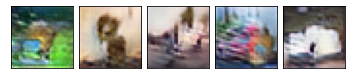

--- EPOCH 9/15 ---
  0%|          | 1/500 [00:00<06:08,  1.35it/s]

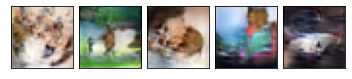

 20%|██        | 101/500 [01:08<04:29,  1.48it/s]

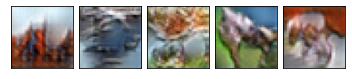

 40%|████      | 201/500 [02:16<03:21,  1.49it/s]

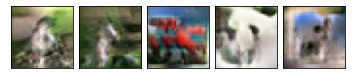

 60%|██████    | 301/500 [03:23<02:14,  1.48it/s]

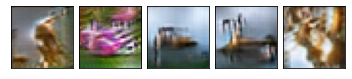

 80%|████████  | 401/500 [04:31<01:06,  1.48it/s]

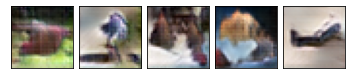

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.2002651735544205
Generator loss:     0.6579204448461533


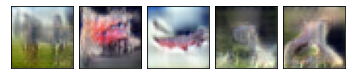

--- EPOCH 10/15 ---
  0%|          | 1/500 [00:00<06:06,  1.36it/s]

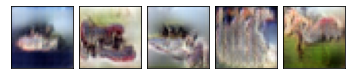

 20%|██        | 101/500 [01:08<04:29,  1.48it/s]

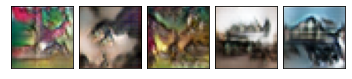

 40%|████      | 201/500 [02:15<03:21,  1.48it/s]

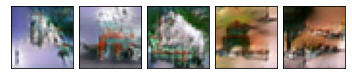

 60%|██████    | 301/500 [03:23<02:13,  1.49it/s]

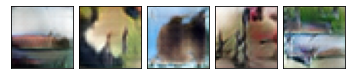

 80%|████████  | 401/500 [04:31<01:06,  1.49it/s]

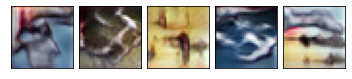

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.167409180521965
Generator loss:     0.6788514229059219
Saved checkpoint.


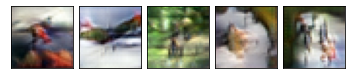

--- EPOCH 11/15 ---
  0%|          | 1/500 [00:00<06:06,  1.36it/s]

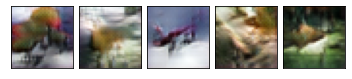

 20%|██        | 101/500 [01:08<04:30,  1.48it/s]

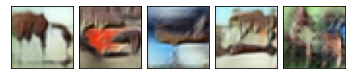

 40%|████      | 201/500 [02:16<03:21,  1.48it/s]

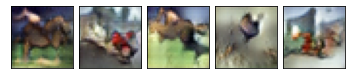

 60%|██████    | 301/500 [03:23<02:14,  1.48it/s]

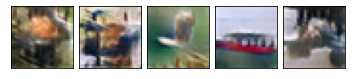

 80%|████████  | 401/500 [04:31<01:07,  1.48it/s]

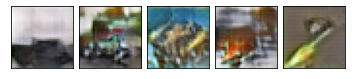

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.1563852899074554
Generator loss:     0.6824078419208527


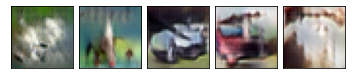

--- EPOCH 12/15 ---
  0%|          | 1/500 [00:00<06:11,  1.34it/s]

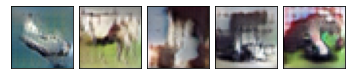

 20%|██        | 101/500 [01:08<04:29,  1.48it/s]

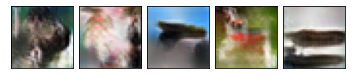

 40%|████      | 201/500 [02:16<03:20,  1.49it/s]

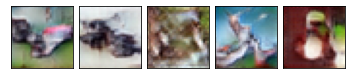

 60%|██████    | 301/500 [03:23<02:14,  1.48it/s]

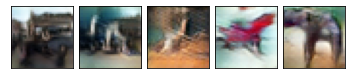

 80%|████████  | 401/500 [04:31<01:06,  1.49it/s]

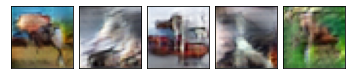

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.146113206744194
Generator loss:     0.6920207558870316


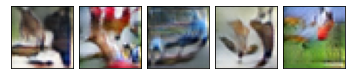

--- EPOCH 13/15 ---
  0%|          | 1/500 [00:00<06:09,  1.35it/s]

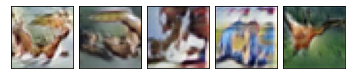

 20%|██        | 101/500 [01:08<04:28,  1.49it/s]

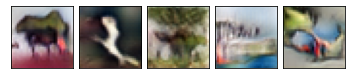

 40%|████      | 201/500 [02:16<03:22,  1.48it/s]

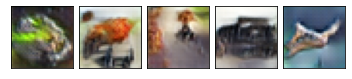

 60%|██████    | 301/500 [03:24<02:14,  1.48it/s]

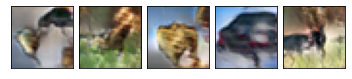

 80%|████████  | 401/500 [04:31<01:06,  1.48it/s]

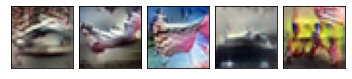

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.143692435860634
Generator loss:     0.6828765916824341


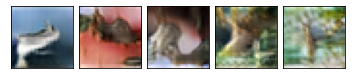

--- EPOCH 14/15 ---
  0%|          | 1/500 [00:00<06:10,  1.35it/s]

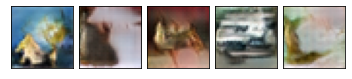

 20%|██        | 101/500 [01:08<04:29,  1.48it/s]

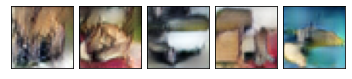

 40%|████      | 201/500 [02:16<03:22,  1.48it/s]

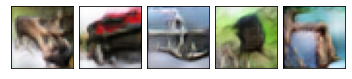

 60%|██████    | 301/500 [03:23<02:14,  1.48it/s]

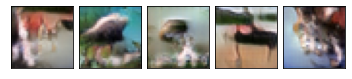

 80%|████████  | 401/500 [04:31<01:07,  1.47it/s]

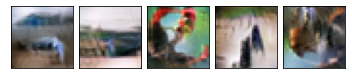

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.1426588253974914
Generator loss:     0.6700390419960022


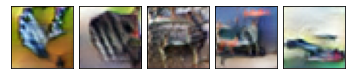

--- EPOCH 15/15 ---
  0%|          | 1/500 [00:00<06:11,  1.34it/s]

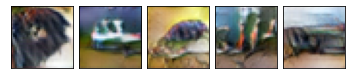

 20%|██        | 101/500 [01:08<04:30,  1.48it/s]

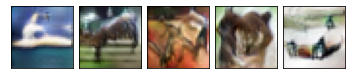

 40%|████      | 201/500 [02:16<03:21,  1.48it/s]

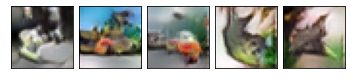

 60%|██████    | 301/500 [03:24<02:15,  1.47it/s]

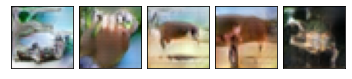

 80%|████████  | 401/500 [04:31<01:06,  1.48it/s]

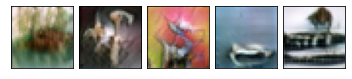

100%|██████████| 500/500 [05:38<00:00,  1.48it/s]
Discriminator loss: 1.1218958419561387
Generator loss:     0.6534666674733162
Saved checkpoint.


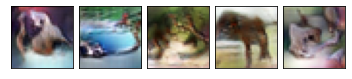

In [10]:
import IPython.display
import tqdm
from acgan import train_batch, save_checkpoint

num_epochs = 15

# if os.path.isfile(f'{checkpoint_file_final}.pt'):
#     print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
#     num_epochs = 0
#     gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
#     checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, y_class) in enumerate(dl_train):
                x_data, y_class = x_data.to(device), y_class.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data, y_class)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()
                
                if batch_idx % 100 == 0:
                    samples, labels = gen.sample(5, with_grad=False)
                    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
                    IPython.display.display(fig)
                    plt.close(fig)
                
        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            
        samples, labels = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

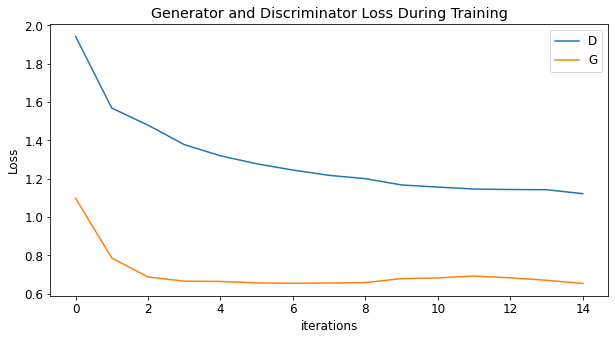

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(dsc_avg_losses,label="D")
plt.plot(gen_avg_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

*** Images Generated from best model:


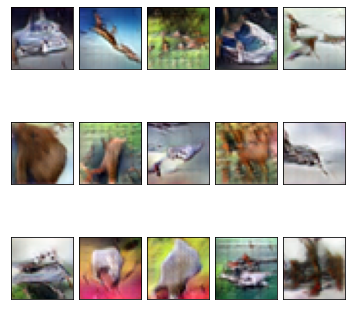

In [12]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples, labels = gen.sample(n=15, with_grad=False)
fig, _ = plot.tensors_as_images(samples.cpu(), nrows=3, figsize=(6,6))

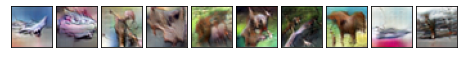

In [13]:
samples, labels = gen.sample_cats(10, [0,1,2,3,4,5,6,7,8,9])
fig, _ = plot.tensors_as_images(samples.cpu())

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


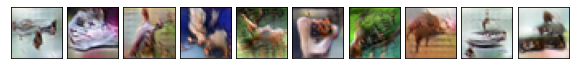

In [18]:
samples, labels = gen.sample_cats(10, [0,1,2,3,4,5,6,7,8,9])
fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(10,5))
print(classes)

In [14]:
fig.savefig('./results/acgan-cifar10')

In [15]:
checkpoint_file = 'checkpoints/acgan-cifar10'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')
torch.save(gen, checkpoint_file)